In [1]:
# TODO set strip width to (in nm):
# - width = 100
# - width = 125
# - width = 150

width = 100

---

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc

In [3]:
import sys
sys.path.append('..')
from simtools import Strip

In [4]:
lx = 600e-9
ly = width * 1e-9

wedge_x = 300e-9
wedge_y = 30e-9
slope =  1
initpattern = 'ix'

In [5]:
s = Strip(lx, ly, 10e-9, 20e-9, 'simulations', initpattern=initpattern)

In [6]:
n = s.system.m.mesh.n.copy()
n[0] += 1  # odd number of cells in x direction to have one cell at the tip of the notch
n

array([241,  40,  12])

In [7]:
s.min_drive(fixed=True)
s.min_drive()

Running OOMMF (ExeOOMMFRunner)[2023/07/16 11:12]... (14.4 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 11:13]... (10.1 s)


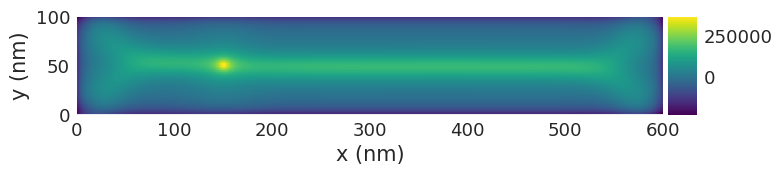

In [8]:
s.system.m.sel('z').z.mpl()

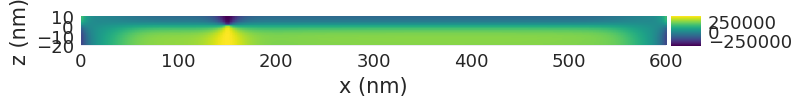

In [9]:
s.system.m.sel('y').z.mpl()

In [10]:
mesh = df.Mesh(p1=(0, 0, -20e-9), p2=(lx, ly, 10e-9), n=n,
               subregions={'bottom': df.Region(p1=(0, 0, -20e-9), p2=(lx, ly, 0)),
                           'top': df.Region(p1=(0, 0, 0), p2=(lx, ly, 10e-9))})

In [11]:
def wedge(x0, y0, m):
    def init_Ms(p):
        x, y, z = p
        if (y - (ly - y0)) > m * (x - x0) and (y - (ly - y0)) > -m * (x - x0):
            return 0
        return 384e3
    return init_Ms

field = df.Field(mesh, nvdim=3, value=s.system.m, norm=wedge(wedge_x, wedge_y, slope), valid='norm')

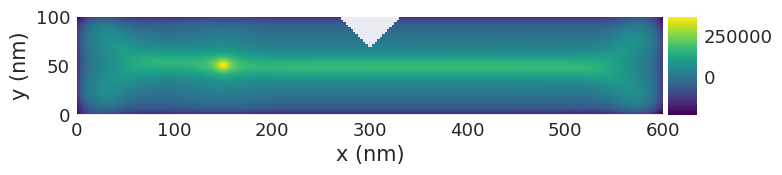

In [12]:
field.sel('z').z.mpl()

In [13]:
s.system.m = field

In [14]:
s.system.energy.dmi.D = {'bottom': -0.00158, 'top': 0.00158}

In [15]:
md = oc.MinDriver()

In [16]:
md.drive(s.system, dirname='simulations')

Running OOMMF (ExeOOMMFRunner)[2023/07/16 11:13]... (12.1 s)


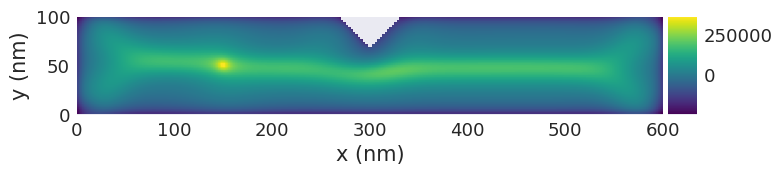

In [17]:
s.system.m.sel('z').z.mpl()

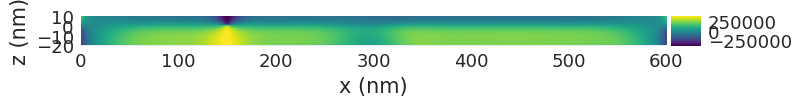

In [18]:
s.system.m.sel('y').z.mpl()

---

In [19]:
import micromagneticdata as mdata

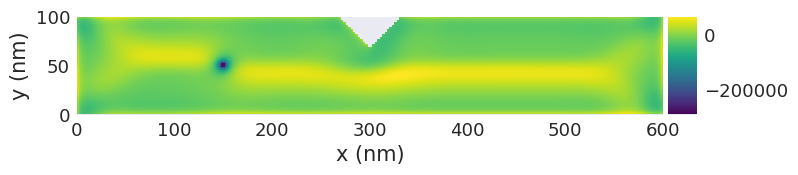

In [20]:
data = mdata.Data(name=s.system.name, dirname='simulations')
initial_m = data[-1][-1]
initial_m.sel(z=1e-9).z.mpl()

---

In [21]:
j_distribution = df.Field.from_file(f'current-{width}.omf')

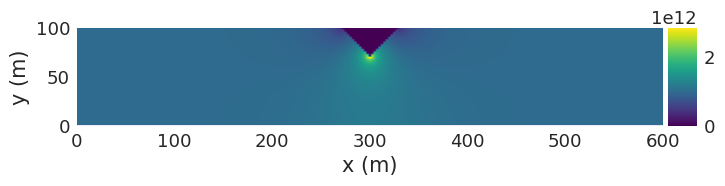

In [22]:
j_distribution.sel('z').norm.mpl()

In [23]:
j_distribution.valid = s.system.m.valid

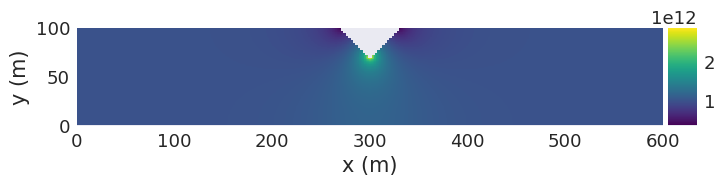

In [24]:
j_distribution.sel('z').norm.mpl()

In [25]:
j0_mean = j_distribution.norm.sel(x=(0, 150)).mean()
j0_mean

array([9.99970328e+11])

In [26]:
muB = 9.274e-24

def J2ux(J, P=.5):
    Ms = Strip.FeGe['Ms']
    return J * P * mm.consts.g * muB / (2 * mm.consts.e * Ms)

In [27]:
s.system.dynamics += mm.ZhangLi(u=0, beta=0.56)

In [28]:
td = oc.TimeDriver()

In [29]:
j0 = 1e12
for j in [2e11, 4e11, 6e11, 7e11, 8e11, 9e11, 1e12, 1.1e12, 1.2e12, 1.5e12, 2e12, 3e12]:
    # update current
    u_field = df.Field(mesh, nvdim=3, value=J2ux(j_distribution.array * j / j0), valid=s.system.m.valid)
    s.system.dynamics.zhangli.u = u_field
    
    # reset magnetisation
    s.system.m.array = initial_m.array
    
    td.drive(s.system, dirname=f"simulations/J_{j:g}", t=10e-9, n=100)

Running OOMMF (ExeOOMMFRunner)[2023/07/16 11:13]... (4977.8 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 12:36]... (5047.2 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 14:00]... (5217.5 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 15:27]... (5218.7 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 16:54]... (5193.3 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 18:21]... (4986.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 19:44]... (5006.5 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 21:07]... (5214.6 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 22:34]... (5073.4 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/16 23:59]... (4978.2 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/17 01:22]... (4852.9 s)
Running OOMMF (ExeOOMMFRunner)[2023/07/17 02:42]... (4994.4 s)
